#**9-3. MNIST DEEP CNN**
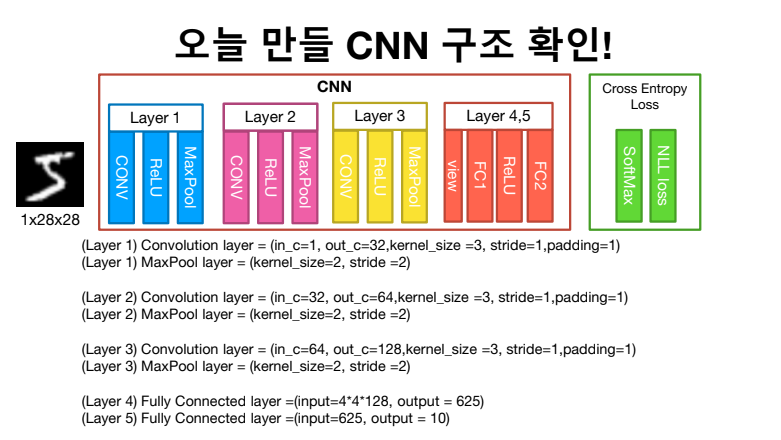

## **1. 라이브러리 가져오기**

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

## **2. GPU 사용 설정, Random value를 위한 seed 설정**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## **3. Parameter 설정**

In [3]:
learning_rate = 0.001
batch_size = 100
training_epochs = 15

## **4. Dataset 가져오기, loader 만들기**

In [4]:
mnist_train = dsets.MNIST(root = './',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)
mnist_test = dsets.MNIST(root = './',
                          train = False,
                          transform = transforms.ToTensor(),
                          download = True)

data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 67576850.58it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 10153021.02it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41983193.08it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2222413.53it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## **5. 학습 모델 만들기**

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # CNN 클래스의 부모 클래스인
                                    # torch.nn.Module 클래스의 생성자를 호출하여 초기화를 수행
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2) #(2, 2)
        )
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding =1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        # Final FC 7x7x64 inputs -> 10 outputs
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size =3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias = True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob)
        )
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # batch수만 고려하고 나머지는 flatten
        out = self.layer4(out)
        out = self.fc2(out)
        return out

model = CNN().to(device)

## **6. Loss Function, Optimizer 선택**

In [6]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## **7. 모델 학습 및 loss check**

In [7]:
total_batch = len(data_loader)
print('Learning started. It takes sometime.')

for epoch in range(1, training_epochs+1):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost/total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.191506103
[Epoch:    2] cost = 0.0545598269
[Epoch:    3] cost = 0.0383968614
[Epoch:    4] cost = 0.0298613328
[Epoch:    5] cost = 0.025512591
[Epoch:    6] cost = 0.0207889285
[Epoch:    7] cost = 0.0178523194
[Epoch:    8] cost = 0.0139354225
[Epoch:    9] cost = 0.0135297636
[Epoch:   10] cost = 0.0124471048
[Epoch:   11] cost = 0.0104616843
[Epoch:   12] cost = 0.00825766567
[Epoch:   13] cost = 0.0107027367
[Epoch:   14] cost = 0.00786881521
[Epoch:   15] cost = 0.00688065216
Learning Finished!


## **8. 학습된 모델 성능 확인**

In [8]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9850000143051147


Label:  4
Prediction:  4


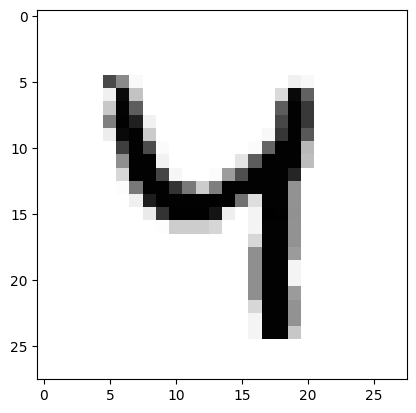

In [10]:
    #Get one and predict
    import matplotlib.pyplot as plt
    import random
    r = random.randint(0, len(mnist_test)-1)
    X_single_data = mnist_test.test_data[r:r+1].view(1, 1, 28, 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r+1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()